# Sentimentment Analysis: Text Classification 
### ヘイトスピーチ: Find out "Hate Speach" on Twitter by 

![title](https://tr2.cbsistatic.com/hub/i/r/2016/09/23/62ce0973-6123-49ef-8b04-987f11461855/resize/770x/483e69e9661155caf2abe04c7dcad51d/candidatesentiment.png)

## MY GOAL   
### Twitterから人種差別や性別差別を含むヘイトスピーチを自動で発見するソフトウェアを作る   

### Motivation     
昨今、SNSなどが
Twitterから人種差別や性別差別に関わるヘイトスピーチを発見する学習モデルを構築します。   
これによりフェイクニュースなどを発見し排除するために機械学習などが使われています。   

## 1. 【データ概要】Import your Data

In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.max_colwidth", 140)

%matplotlib inline

In [2]:
# トレーニングデータとテストデータの準備
train = pd.read_csv("train_E6oV3lV.csv")
test = pd.read_csv("test_tweets_anuFYb8.csv")

In [3]:
# 目的変数であるlabel=1がヘイトスピーチに該当します 
# 欠損値はない綺麗なデータ
print(train.isnull().sum())
print("\n", train.shape)
train.head()

id       0
label    0
tweet    0
dtype: int64

 (31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #fa..."
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


## 2. 【前処理】 Preprocessing text 

自然言語処理では、膨大な文字数により特徴量の次元数が爆発的になり、容易に過学習となる。よって、大胆に前処理を行なっていく必要がある。   

![title](https://mlwhiz.com/images/text_processing_flow_1.png)

In [6]:
# まずはtweetの構造を確認する
train.iloc[0, 2]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

### A) Removing Twitter Handles (@user) -ユーザー名の削除-

@マーク以降の文字列は「ユーザー」名のため除外

In [7]:
all_data = train.append(test, ignore_index=True)
all_data.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(49159, 3)

In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, "", input_txt)
        
    return input_txt

In [9]:
all_data['tidy_tweet'] = np.vectorize(remove_pattern)(all_data['tweet'], "@[\w]*")

In [10]:
all_data['tidy_tweet'].head()

0                     when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1      thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                                                 bihday your majesty
3                              #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4                                                                              factsguide: society now    #motivation
Name: tidy_tweet, dtype: object

### B) Removing Punctuations, Numbers, and Special Characters -句読点や数字、記号の削除-

句読点や数字、記号を取り除く

In [11]:
all_data['tidy_tweet'] = all_data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [12]:
all_data['tidy_tweet'].head()

0                     when a father is dysfunctional and is so selfish he drags his kids into his dysfunction    #run
1      thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx     #disapointed #getthanked
2                                                                                                 bihday your majesty
3                              #model   i love u take with u all the time in ur                                      
4                                                                              factsguide  society now    #motivation
Name: tidy_tweet, dtype: object

### C) Removing Short Words -意味のない短い単語を削除する-

In [13]:
all_data['tidy_tweet'] = all_data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [14]:
# ユーザー名やisなど短い単語が消えていることを確認する
print("Before :", train.iloc[0, 2])
print("After :", all_data.iloc[0, 3])
all_data.head()

Before :  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
After : when father dysfunctional selfish drags kids into dysfunction #run


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


### D) Tokenization -文章を単語に区切る- 

In [15]:
tokenized_tweet = all_data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

### E) Stemming -語幹が同じものを統一する-

In [16]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

stemmed_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
stemmed_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [17]:
for i in range(len(stemmed_tweet)):
    stemmed_tweet[i] = ' '.join(stemmed_tweet[i])

all_data["tidy_tweet"] = stemmed_tweet
all_data["tidy_tweet"].head()

0                  when father dysfunct selfish drag kid into dysfunct #run
1    thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2                                                       bihday your majesti
3                                                #model love take with time
4                                                  factsguid societi #motiv
Name: tidy_tweet, dtype: object

## 3. 【探索的データ解析】EDA and Visualization

ヘイトスピーチを含むツイートの統計的な特徴を、データの可視化によって理解していく。

### A) Understanding the common words used in the tweets: WordCloud

#### 問題のないと分類されたツイートによく出る単語

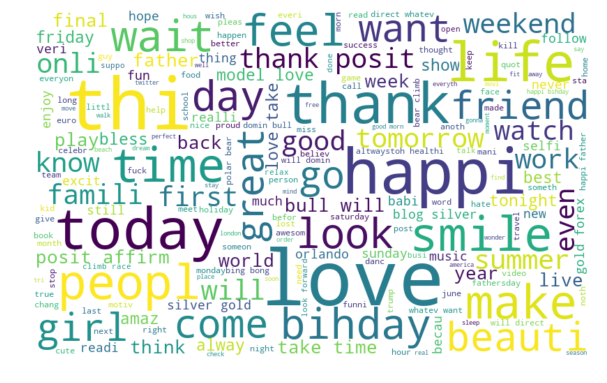

In [20]:
normal_words =' '.join([text for text in all_data['tidy_tweet'][all_data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color="white", max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### ヘイトスピーチに分類されたツイートによく出る単語

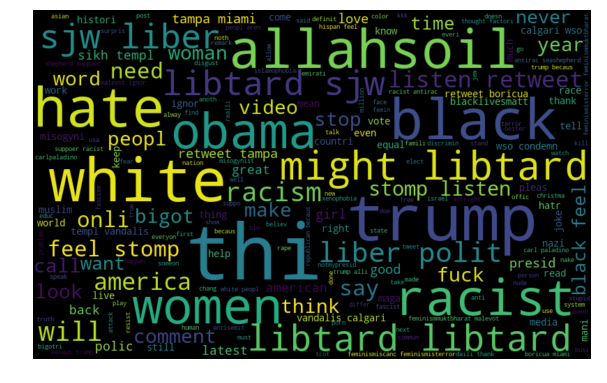

In [21]:
negative_words = ' '.join([text for text in all_data['tidy_tweet'][all_data['label'] == 1]])

wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### B) Understanding the impact of Hashtags on tweets sentiment

In [22]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags